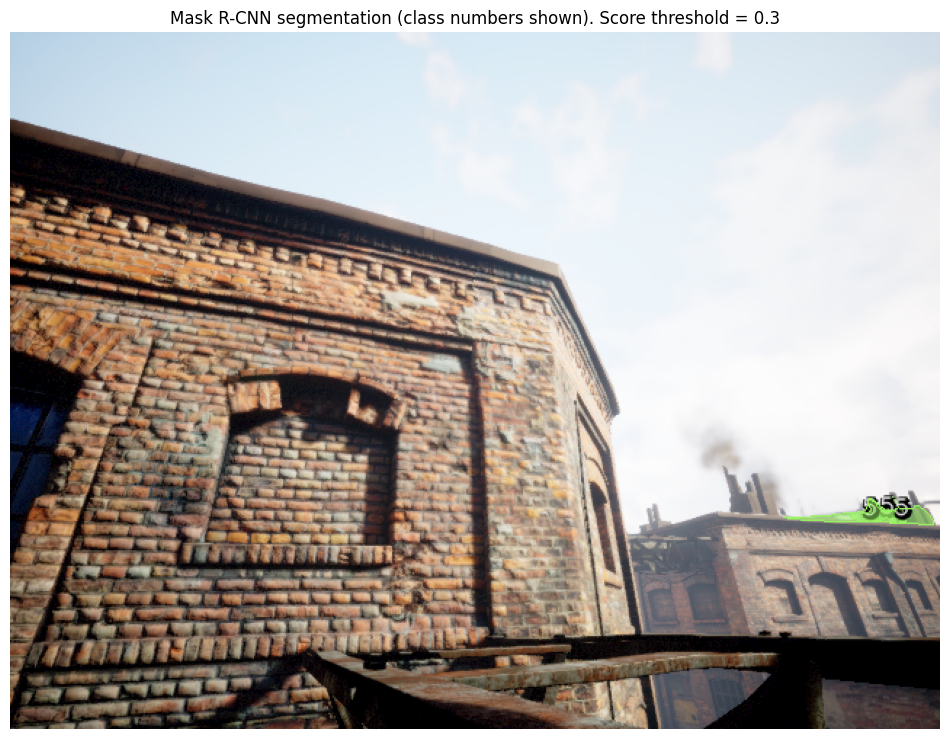

In [3]:
import sys
import random
import numpy as np
import torch
import torchvision
from torchvision.transforms import functional as F
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def random_color(seed):
    rnd = random.Random(seed)
    return (rnd.randint(0,255), rnd.randint(0,255), rnd.randint(0,255))

def visualize_masks_on_image(orig_bgr, masks, labels, scores, score_thresh=0.5, alpha=0.5, min_area=100):
    """
    orig_bgr: HxWx3 uint8 (OpenCV BGR)
    masks: Tensor (N, 1, H, W) with float mask logits in [0,1] (torch)
    labels: Tensor (N,) ints
    scores: Tensor (N,) floats
    """
    out = orig_bgr.copy()
    H, W = orig_bgr.shape[:2]
    used_colors = {}

    # iterate detections in descending score
    order = torch.argsort(scores, descending=True)
    for idx in order:
        score = float(scores[idx])
        if score < score_thresh:
            continue
        mask = masks[idx, 0].cpu().numpy()  # HxW float mask (0..1)
        # binarize
        mask_bin = (mask > 0.5).astype(np.uint8)
        if mask_bin.sum() < min_area:
            continue

        label = int(labels[idx].item())  # class number
        # same color for same class id
        if label not in used_colors:
            used_colors[label] = random_color(label + 12345)  # deterministic per label
        color = used_colors[label]

        # Create colored mask overlay
        colored_mask = np.zeros_like(out, dtype=np.uint8)
        colored_mask[mask_bin == 1] = color  # fill color where mask is 1

        # Blend the overlay with the image
        # cv2.addWeighted works per-channel
        mask_3c = np.stack([mask_bin]*3, axis=-1)
        # alpha blending only on mask region
        out = np.where(mask_3c==1,
                       (out * (1 - alpha) + colored_mask * alpha).astype(np.uint8),
                       out)

        # compute centroid for label text
        ys, xs = np.where(mask_bin == 1)
        if len(xs) > 0:
            cx = int(xs.mean())
            cy = int(ys.mean())
            text = str(label)  # class numbering only
            # put text with black outline for readability
            font = cv2.FONT_HERSHEY_SIMPLEX
            scale = max(0.5, min(W, H) / 1000.0)  # scale text with image size
            thickness = max(1, int(scale * 2))
            # outline
            cv2.putText(out, text, (cx+1, cy+1), font, scale, (0,0,0), thickness+2, lineType=cv2.LINE_AA)
            # foreground text (white for contrast)
            cv2.putText(out, text, (cx, cy), font, scale, (255,255,255), thickness, lineType=cv2.LINE_AA)

        # draw contour around mask
        contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            cv2.drawContours(out, [cnt], -1, color, max(1, int(scale*2)))

    return out

def run_on_image(image_path, device=None, score_thresh=0.5):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # load image (PIL) and convert to tensor in [0,1]
    pil = Image.open(image_path).convert("RGB")
    img_tensor = F.to_tensor(pil).to(device)  # C,H,W float32

    # load pretrained Mask R-CNN
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    model.to(device).eval()

    # forward (model expects list[Tensor])
    with torch.no_grad():
        outputs = model([img_tensor])[0]

    # outputs: dict with keys 'boxes','labels','scores','masks'
    masks = outputs.get("masks")          # (N,1,H,W) float masks with values ~0..1
    labels = outputs.get("labels")        # (N,)
    scores = outputs.get("scores")        # (N,)

    # convert PIL RGB to OpenCV BGR uint8 for drawing
    orig_np = np.array(pil)[:, :, ::-1].copy()  # HxWx3 BGR

    vis = visualize_masks_on_image(orig_np, masks, labels, scores, score_thresh=score_thresh, alpha=0.5)

    # Show result with matplotlib (convert BGR->RGB)
    vis_rgb = vis[:, :, ::-1]
    plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(vis_rgb)
    plt.title(f"Mask R-CNN segmentation (class numbers shown). Score threshold = {score_thresh}")
    plt.show()

if __name__ == "__main__":


    img_path = "datasets/TartanAir/AbandonedFactory/P001/image_left/000000_left.png"
    score_th = 0.3
    run_on_image(img_path, score_thresh=score_th)


Mask shape: (480, 640)
Unique labels: [ 13  96 110 129 152 153 160 164 167 178 184 196 197 199 200 205 220 222
 226 227 245 246 250 252]


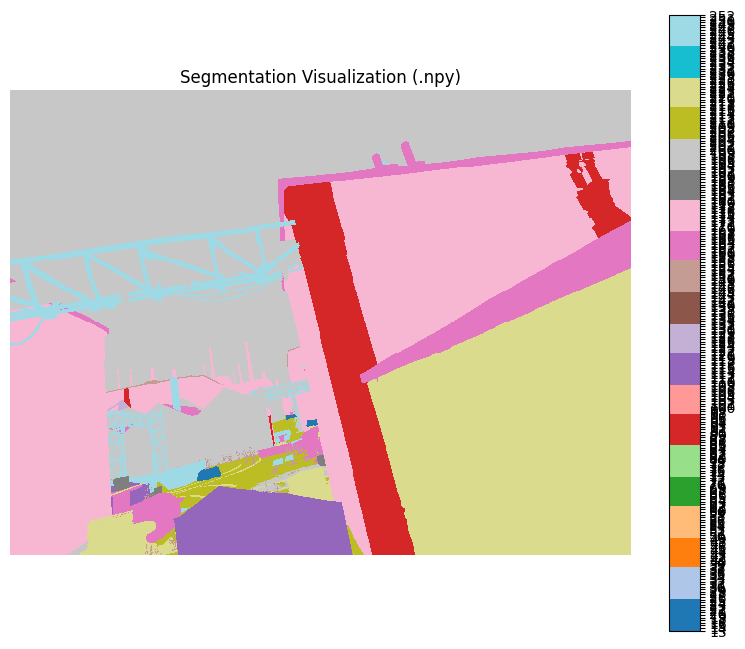

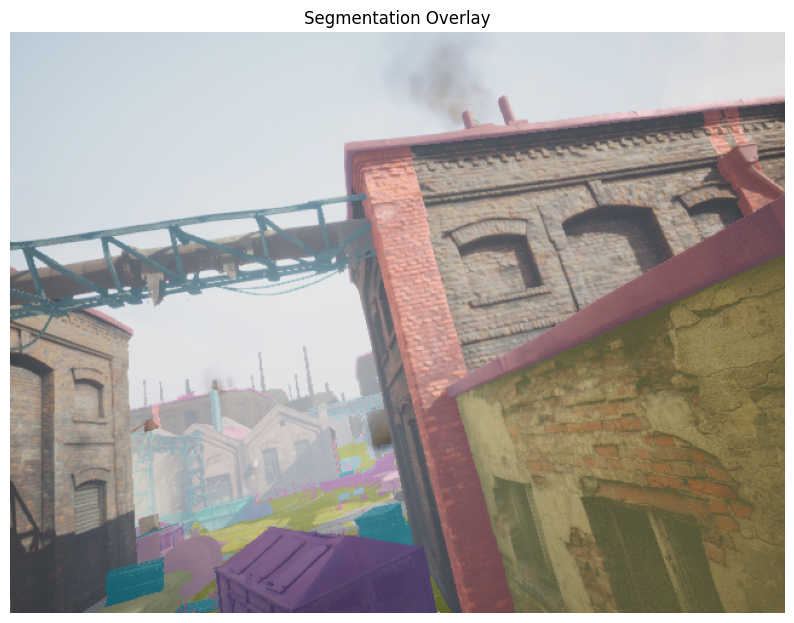

In [6]:
import numpy as np
seg_path = 'datasets/TartanAir/AbandonedFactory/P001/seg_left/000100_left_seg.npy'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ---- Load the segmentation mask ----
mask = np.load(seg_path)  # shape: (H, W)

# Optional: check shape and dtype
print("Mask shape:", mask.shape)
print("Unique labels:", np.unique(mask))

# ---- Create a color map ----
# Use a large categorical colormap so each class is distinct
num_classes = int(mask.max()) + 1
cmap = plt.get_cmap('tab20', num_classes)

# ---- Plot the segmentation ----
plt.figure(figsize=(10, 8))
plt.imshow(mask, cmap=cmap, interpolation='nearest')
plt.colorbar(ticks=range(num_classes))
plt.title("Segmentation Visualization (.npy)")
plt.axis("off")
plt.show()

import cv2

# Load original image
image = cv2.cvtColor(cv2.imread("datasets/TartanAir/AbandonedFactory/P001/image_left/000100_left.png"), cv2.COLOR_BGR2RGB)

# Resize mask if needed
if mask.shape != image.shape[:2]:
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

# Convert mask to color
colored_mask = cmap(mask / num_classes)[:, :, :3]  # drop alpha channel
overlay = (0.6 * image/255.0 + 0.4 * colored_mask)

plt.figure(figsize=(10, 8))
plt.imshow(overlay)
plt.title("Segmentation Overlay")
plt.axis("off")
plt.show()
